In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings('ignore')

/Users/alex/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/alex/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#### Loading:
def load_data_with_chunks(local_paths,  chunk_size=10**6):
    """
    Loads data in chunks, either locally or from the cloud.
    
    Args:
        local_paths (list): Paths to local CSV files.
        cloud_url (str): Google Drive/direct download URL (optional).
        chunk_size (int): Rows per chunk.
        filter_store_ids (list): List of store_nbrs to filter by (optional).
    
    Returns:
        pd.DataFrame: Combined data or None if failed.
    """
    # 1. Attempt: Load local file (with chunking)
    for path in local_paths:
        if os.path.exists(path):
            try:
                chunks = []
                for chunk in pd.read_csv(path, chunksize=chunk_size, sep=','):
                    chunks.append(chunk)
                df = pd.concat(chunks, ignore_index=True)
                print(f"Successfully loaded local data (chunked): {path}")
                return df
            except Exception as e:
                print(f"Error loading {path}: {e}")



# Example call
store_ids = [1, 5, 10]  # Example filter
merged_df = load_data_with_chunks(
    local_paths=['../data/df_merged.csv']
)

# Preliminary data analysis
print(f"Dataset size: {merged_df.shape}")
merged_df.head()

Successfully loaded local data (chunked): ../data/df_merged.csv
Dataset size: (35692996, 12)


,store_nbr,item_nbr,date,unit_sales,onpromotion,z_score,year,month,day,weekday,type,family
0,24,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I
1,51,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I
2,26,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I
3,27,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I
4,28,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I


# 1. Feature Engeneering

In [3]:
def create_advanced_features(df, lags_range=range(1, 29)):
    """
    Erstellt erweiterte Features für Time-Series-Modelle (XGBoost etc.).
    Die ursprünglichen Features bleiben vollständig erhalten.
    """
    print("▶ Starte erweitertes Feature Engineering...")

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

    grouped = df.groupby(['store_nbr', 'item_nbr'])

    # --- Lag Features ---
    important_lags = [1, 7, 14, 30]
    for lag in important_lags:
        df[f'lag_{lag}'] = grouped['unit_sales'].shift(lag)

    for lag in lags_range:
        if lag not in important_lags:
            df[f'lag_{lag}'] = grouped['unit_sales'].shift(lag)

    # --- Rolling Features ---
    df['rolling_mean_7'] = grouped['unit_sales'].shift(1).rolling(7, min_periods=1).mean()
    df['rolling_std_7'] = grouped['unit_sales'].shift(1).rolling(7, min_periods=1).std()
    
    # --- Trend Features ---
    df['sales_trend_7'] = df['lag_1'] / df['rolling_mean_7'] - 1
    

    # --- Interaktionsfeatures ---
    df['promo_x_lag_7'] = df['onpromotion'] * df['lag_7']
    df['promo_x_rolling_mean_7'] = df['onpromotion'] * df['rolling_mean_7']


    # --- Target Engineering ---

    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

    # NaN/Inf bereinigen
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(method='bfill').fillna(0)

    print(f"✔ Feature Engineering abgeschlossen — Shape: {df.shape}")
    return df

In [4]:
# ============================================================================
# 2) FEATURE SIGNIFICANCE ANALYSIS
# ============================================================================

def analyze_feature_significance(df, target_col='unit_sales',
                                 top_n=20, clip_threshold=1e9,
                                 sample_size=200000, random_state=42):
    """
    Analysiert die Relevanz aller numerischen Features anhand von
    (1) absoluter Korrelation
    (2) Mutual Information
    """
    print("\n" + "=" * 70)
    print("▶ Starte Feature-Signifikanzanalyse")
    print("=" * 70)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude = {target_col, 'unit_sales_log', 'has_sales'}
    numeric_cols = [c for c in numeric_cols if c not in exclude]

    df_sample = df.sample(n=sample_size, random_state=random_state) if len(df) > sample_size else df.copy()

    results = []

    for feature in numeric_cols:
        x = df_sample[feature].astype(float).replace([np.inf, -np.inf], np.nan)
        if x.nunique(dropna=True) <= 1:
            continue

        x = x.fillna(x.median()).clip(-clip_threshold, clip_threshold)

        y = df_sample[target_col].astype(float).replace([np.inf, -np.inf], np.nan)
        y = y.fillna(y.median())

        try:
            corr = abs(np.corrcoef(x, y)[0, 1])
        except Exception:
            corr = 0.0
        corr = 0.0 if np.isnan(corr) else corr

        try:
            mi = mutual_info_regression(x.values.reshape(-1, 1), y.values, random_state=random_state)[0]
        except Exception:
            mi = 0.0

        importance = (corr + mi) / 2

        results.append({
            'feature': feature,
            'correlation': corr,
            'mutual_info': mi,
            'variance': float(x.var()),
            'importance_score': importance,
        })

    significance_df = (pd.DataFrame(results)
                       .sort_values('importance_score', ascending=False)
                       .reset_index(drop=True))

    print("✔ Top Features:")
    print(significance_df.head(top_n))
    return significance_df


In [5]:
# ============================================================================
# 3) FINALES FEATURESET
# ============================================================================

def build_final_feature_set(df, merged_df, significance_df, max_top_features=5):
    """
    Erstellt ein finales, reduziertes Feature-Set.
    Beinhaltet nur:
      - die ursprünglichen Features aus merged_df
      - die Top-N wichtigsten Features laut Signifikanzanalyse
    Core Features werden bevorzugt hinzugefügt.
    """

    print("\n" + "=" * 70)
    print("▶ Erstelle finales Feature-Set")
    print("=" * 70)

    # Core Features (nur wenn im df vorhanden)
    core_features = [
        "onpromotion", "rolling_std_7", "lag_1", "lag_7", "lag_28"
    ]
    core_features = [f for f in core_features if f in df.columns]

    # Top Features aus Signifikanzanalyse
    ranked_features = [f for f in significance_df['feature'].tolist() if f in df.columns]
    top_features = ranked_features[:max_top_features]

    # Ursprüngliche Features aus merged_df
    original_features = [f for f in merged_df.columns if f in df.columns]

    # Final: ursprüngliche Features + Core + Top Features (ohne Duplikate)
    final_model_features = list(dict.fromkeys(original_features + core_features + top_features))

    print("Original Features aus merged_df:", original_features)
    print("Core Features:", core_features)
    print(f"Top {max_top_features} Features aus Signifikanzanalyse:", top_features)
    print("Final Model Features:", final_model_features)

    # Nur die ausgewählten Features zurückgeben
    df_final = df[final_model_features].copy()

    return df_final, final_model_features



In [6]:
# ============================================================================
# 4) PIPELINE
# ============================================================================

def run_feature_engineering_pipeline_xgb(merged_df):
    print("\n▶ STARTE XGBoost Feature Engineering Pipeline")

    df_with_features = create_advanced_features(merged_df)
    significance_df = analyze_feature_significance(df_with_features)

    print("✔ Pipeline abgeschlossen.")

    return df_with_features, significance_df


In [7]:
# ============================================================================
# AUSFÜHRUNG
# ============================================================================

df_with_features, significance_df = run_feature_engineering_pipeline_xgb(merged_df)
df_final, final_feature_list = build_final_feature_set(
    df_with_features, merged_df, significance_df, max_top_features=5
)

print("\n✔ Finaler DataFrame:", df_final.shape)
print("✔ Verwendete Modellfeatures:", final_feature_list)

df_final.head()


▶ STARTE XGBoost Feature Engineering Pipeline
▶ Starte erweitertes Feature Engineering...
✔ Feature Engineering abgeschlossen — Shape: (35692996, 47)

▶ Starte Feature-Signifikanzanalyse
✔ Top Features:
           feature  correlation  mutual_info   variance  importance_score
0            lag_1     0.935996     0.777513  54.589272          0.856755
1   rolling_mean_7     0.922307     0.742995  51.435277          0.832651
2            lag_2     0.912393     0.659619  57.060879          0.786006
3            lag_3     0.893610     0.592794  58.435325          0.743202
4            lag_4     0.884471     0.544642  57.566255          0.714556
5            lag_5     0.878884     0.511259  57.064580          0.695071
6            lag_6     0.872146     0.488173  55.750295          0.680160
7            lag_7     0.863825     0.477628  55.474796          0.670727
8            lag_8     0.857131     0.458379  54.837547          0.657755
9            lag_9     0.847955     0.445618  54.833597 

,store_nbr,item_nbr,date,unit_sales,onpromotion,z_score,year,month,day,weekday,type,family,rolling_std_7,lag_1,lag_7,lag_28,rolling_mean_7,lag_2,lag_3,lag_4
0,24,96995,2013-01-02,0.0,0,0.0,2013,1,2,2,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24,96995,2013-01-03,0.0,0,0.0,2013,1,3,3,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,96995,2013-01-04,0.0,0,0.0,2013,1,4,4,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,96995,2013-01-05,0.0,0,0.0,2013,1,5,5,Work Day,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,96995,2013-01-06,0.0,0,0.0,2013,1,6,6,Weekend,GROCERY I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



▶ VISUALISIERUNG DER TOP FEATURES

Top 20 sinnvollste Features für XGBoost:
['lag_1', 'rolling_mean_7', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_15', 'lag_14', 'lag_16', 'lag_17', 'z_score', 'lag_18']


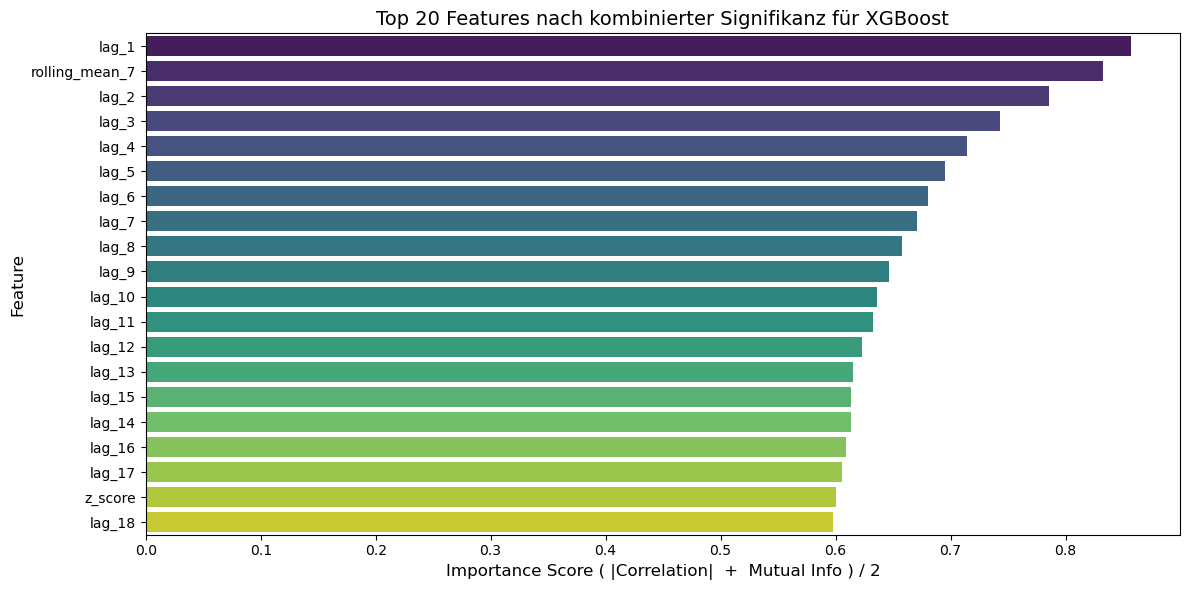

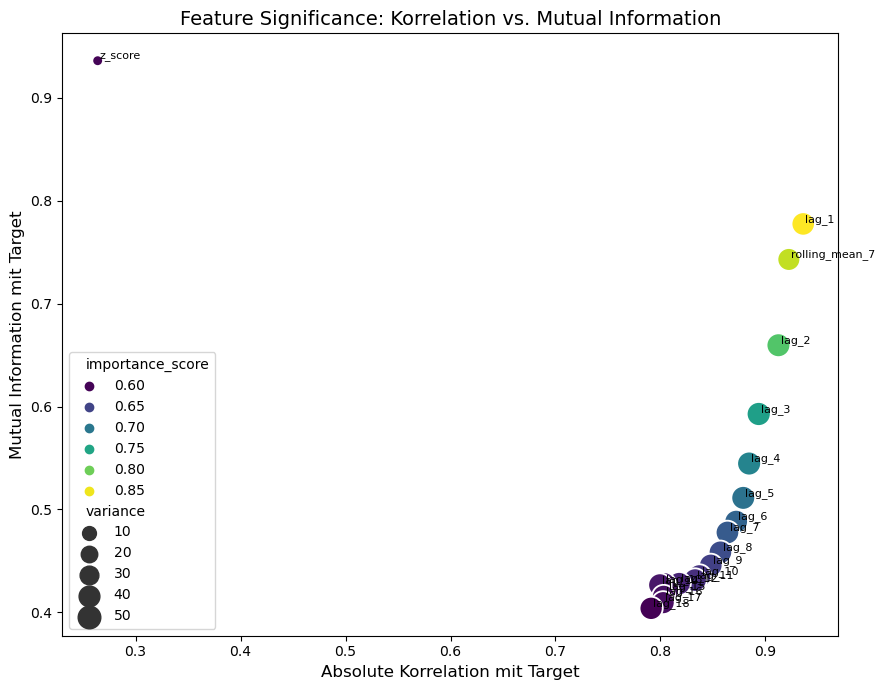

In [8]:
# =============================================================================
# VISUALISIERUNG & SELEKTION DER TOP FEATURES
# =============================================================================

print("\n" + "=" * 70)
print("▶ VISUALISIERUNG DER TOP FEATURES")
print("=" * 70)

# Sicherstellen, dass Signifikanz-Daten vorhanden sind
if significance_df is None or significance_df.empty:
    print("Keine Signifikanzdaten vorhanden – Visualisierung wird übersprungen.")
else:
    # Top 20 Features auswählen
    top_features_df = significance_df.head(20).copy()

    # Liste der Top-Features
    top_features_list = top_features_df['feature'].tolist()
    print("\nTop 20 sinnvollste Features für XGBoost:")
    print(top_features_list)

    # ===========================================
    # 1) BARPLOT – Importance Score
    # ===========================================
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='importance_score',
        y='feature',
        data=top_features_df,
        palette='viridis'
    )
    plt.title("Top 20 Features nach kombinierter Signifikanz für XGBoost", fontsize=14)
    plt.xlabel("Importance Score ( |Correlation|  +  Mutual Info ) / 2", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

    # ===========================================
    # 2) Streudiagramm – Correlation vs. Mutual Information
    # ===========================================
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        x='correlation',
        y='mutual_info',
        size='variance',
        hue='importance_score',
        data=top_features_df,
        sizes=(60, 300),
        palette='viridis',
        legend='brief'
    )

    # Feature Labels neben die Punkte setzen
    for _, row in top_features_df.iterrows():
        plt.text(
            row['correlation'] + 0.002,
            row['mutual_info'] + 0.002,
            row['feature'],
            fontsize=8
        )

    plt.title("Feature Significance: Korrelation vs. Mutual Information", fontsize=14)
    plt.xlabel("Absolute Korrelation mit Target", fontsize=12)
    plt.ylabel("Mutual Information mit Target", fontsize=12)
    plt.tight_layout()
    plt.show()

In [9]:
df_final.columns

Index(['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion', 'z_score',
       'year', 'month', 'day', 'weekday', 'type', 'family', 'rolling_std_7',
       'lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'lag_2', 'lag_3',
       'lag_4'],
      dtype='object')

In [10]:
df_final.to_csv('../data/df_final_xgboost_full.csv', index=False)